# Import libraries

In [45]:
import os, time
import random
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Must be set BEFORE any CUDA operation
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import pickle

SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed()
print(f"Random seed fixed to {SEED}")
!pwd


Random seed fixed to 42
/nfs/u50/zhanh279/SemEval-2026/subTask1/Baselines


# Import dataset and features

In [46]:
train_embeddings=pd.read_pickle('../data/task1_embedding_train.pickle')
val_embeddings=pd.read_pickle('../data/task1_embedding_val.pickle')
train_sims=pd.read_pickle('../data/train+sim.pickle')
val_sims=pd.read_pickle('../data/val+sim.pickle')
train_LIWC=pd.read_pickle("../data/task1_LIWC_train.pickle")
val_LIWC=pd.read_pickle("../data/task1_LIWC_val.pickle")



In [47]:
# Check data structure
print("Data shapes:")
print(f"  train_embeddings: {train_embeddings.shape}")
print(f"  val_embeddings: {val_embeddings.shape}")
print(f"  train_sims: {train_sims.shape}")
print(f"  val_sims: {val_sims.shape}")
print(f"  train_LIWC: {train_LIWC.shape}")
print(f"  val_LIWC: {val_LIWC.shape}")

print("\nColumns in train_embeddings:")
print(list(train_embeddings.columns))

print("\nColumns in train_sims:")
print(list(train_sims.columns))

print("\nColumns in train_LIWC:")
print(list(train_LIWC.columns)[:10])


Data shapes:
  train_embeddings: (2211, 9)
  val_embeddings: (553, 9)
  train_sims: (2211, 18)
  val_sims: (553, 18)
  train_LIWC: (2211, 90)
  val_LIWC: (553, 90)

Columns in train_embeddings:
['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'embedding']

Columns in train_sims:
['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'Arousal.0.sim', 'Arousal.1.sim', 'Arousal.2.sim', 'Arousal.3.sim', 'Arousal.4.sim', 'Valence.0.sim', 'Valence.1.sim', 'Valence.2.sim', 'Valence.3.sim', 'Valence.4.sim']

Columns in train_LIWC:
['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'text_tokens', 'text_liwc_tokens']


# Merge data together

In [48]:

# Data preparation: combine all features (LIWC + Embedding + Sims + User embedding)

print("FULL BASELINE MODEL: LIWC + EMBEDDING + SIMS + USER_ID")

# Load target data
train_targets = pd.read_pickle("../data/train.pickle")
val_targets = pd.read_pickle("../data/val.pickle")

# Reset indices for alignment
train_sims = train_sims.reset_index(drop=True)
val_sims = val_sims.reset_index(drop=True)
train_LIWC = train_LIWC.reset_index(drop=True)
val_LIWC = val_LIWC.reset_index(drop=True)
train_embeddings = train_embeddings.reset_index(drop=True)
val_embeddings = val_embeddings.reset_index(drop=True)
train_targets = train_targets.reset_index(drop=True)
val_targets = val_targets.reset_index(drop=True)

# Extract user IDs and targets
train_user_ids = train_targets['user_id'].values
val_user_ids = val_targets['user_id'].values
y_train = train_targets[['valence', 'arousal']].values.astype(float)
y_val = val_targets[['valence', 'arousal']].values.astype(float)

# Extract LIWC features (numeric columns only, skip metadata and targets)
# Exclude: user_id, text_id, valence, arousal, collection_phase, is_words, num_tokens
exclude_cols = ['user_id', 'text_id', 'valence', 'arousal', 'collection_phase', 'is_words', 'num_tokens']
liwc_feature_cols = [col for col in train_LIWC.columns if col not in exclude_cols and col not in ['text', 'timestamp', 'text_tokens', 'text_liwc_tokens']]
train_liwc_features = train_LIWC[liwc_feature_cols].values.astype(float)
val_liwc_features = val_LIWC[liwc_feature_cols].values.astype(float)

# ---- Length normalization: divide raw counts by num_tokens ----
train_num_tokens = train_LIWC['num_tokens'].values.astype(float).clip(min=1).reshape(-1, 1)
val_num_tokens   = val_LIWC['num_tokens'].values.astype(float).clip(min=1).reshape(-1, 1)

train_liwc_features = train_liwc_features / train_num_tokens
val_liwc_features   = val_liwc_features   / val_num_tokens

# Explicitly encode log(num_tokens) as a length feature
train_log_len = np.log1p(train_num_tokens)
val_log_len   = np.log1p(val_num_tokens)

train_liwc_features = np.hstack([train_liwc_features, train_log_len])
val_liwc_features   = np.hstack([val_liwc_features,   val_log_len])
# ---------------------------------------------------------------

# Standardize LIWC features
scaler_liwc = StandardScaler()
train_liwc_features = scaler_liwc.fit_transform(train_liwc_features)
val_liwc_features = scaler_liwc.transform(val_liwc_features)

# Embedding features - extract from 'embedding' column (no scaler)
train_emb_features = np.array([np.array(x) for x in train_embeddings['embedding'].values])
val_emb_features = np.array([np.array(x) for x in val_embeddings['embedding'].values])

# ---- is_words feature (True=1, False=0) — sourced from LIWC DataFrame (consistent source) ----
train_is_words = train_LIWC['is_words'].values.astype(int).reshape(-1, 1)
val_is_words   = val_LIWC['is_words'].values.astype(int).reshape(-1, 1)

# ---- token_num: count tokens in 'text' column (vectorized) ----
# is_words=True → comma-split (feeling words); is_words=False → whitespace-split (essays)
def _count_tokens(liwc_df):
    texts     = liwc_df['text'].astype(str).values
    is_w_mask = liwc_df['is_words'].astype(bool).values
    # comma-split for feeling words, whitespace-split for essays
    counts_words  = np.array([len([w for w in t.split(',') if w.strip()]) for t in texts[is_w_mask]])
    counts_essays = np.array([len(t.split()) for t in texts[~is_w_mask]])
    result = np.empty(len(texts), dtype=float)
    result[is_w_mask]  = counts_words
    result[~is_w_mask] = counts_essays
    return np.maximum(result, 1).reshape(-1, 1)

_train_tok_raw = _count_tokens(train_LIWC)
_val_tok_raw   = _count_tokens(val_LIWC)
scaler_token   = StandardScaler()
train_token_num = scaler_token.fit_transform(np.log1p(_train_tok_raw))
val_token_num   = scaler_token.transform(np.log1p(_val_tok_raw))
print(f"  token_num range: train {int(_train_tok_raw.min())}–{int(_train_tok_raw.max())}, "
      f"val {int(_val_tok_raw.min())}–{int(_val_tok_raw.max())}")
pickle.dump(scaler_token, open("../scaler_token.pkl", "wb"))

# ---- feeling_words_rep: multi-hot over feeling-word vocabulary ----
# Vocabulary built from is_words=True training items ONLY (no val leakage)
from collections import Counter as _Counter

_isw_mask = train_LIWC['is_words'].astype(bool)
_word_cnt  = _Counter()
for _txt in train_LIWC.loc[_isw_mask, 'text']:
    _word_cnt.update([w.strip().lower() for w in str(_txt).split(',') if w.strip()])

FEELING_MIN_FREQ  = 2
feeling_vocab     = sorted([w for w, c in _word_cnt.items() if c >= FEELING_MIN_FREQ])
feeling_word2idx  = {w: i for i, w in enumerate(feeling_vocab)}
FEELING_VOCAB_SIZE = len(feeling_vocab)
print(f"  feeling_words vocab: {FEELING_VOCAB_SIZE} words (min_freq={FEELING_MIN_FREQ})")
pickle.dump({'vocab': feeling_vocab, 'word2idx': feeling_word2idx},
            open("../feeling_vocab.pkl", "wb"))

def _encode_feeling(liwc_df, word2idx, vocab_size):
    """Multi-hot for is_words=True rows; zero vector for is_words=False."""
    n            = len(liwc_df)
    mat          = np.zeros((n, vocab_size), dtype=np.float32)
    is_words_arr = liwc_df['is_words'].astype(bool).values
    texts        = liwc_df['text'].values
    for i, (is_w, txt) in enumerate(zip(is_words_arr, texts)):
        if is_w:
            for w in [x.strip().lower() for x in str(txt).split(',') if x.strip()]:
                if w in word2idx:
                    mat[i, word2idx[w]] = 1.0
    # is_words=False rows remain zero vectors
    return mat

train_feeling_rep = _encode_feeling(train_LIWC, feeling_word2idx, FEELING_VOCAB_SIZE)
val_feeling_rep   = _encode_feeling(val_LIWC,   feeling_word2idx, FEELING_VOCAB_SIZE)
# ---------------------------------------------------------------

# Extract sim features (columns with 'sim' in name)
sim_cols = [col for col in train_sims.columns if 'sim' in col.lower()]
train_sim_features = train_sims[sim_cols].values.astype(float)
val_sim_features = val_sims[sim_cols].values.astype(float)

# Standardize sim features
scaler_sim = StandardScaler()
train_sim_features = scaler_sim.fit_transform(train_sim_features)
val_sim_features = scaler_sim.transform(val_sim_features)

# Save scalers (no scaler_emb)
pickle.dump(scaler_liwc, open("../scaler_liwc.pkl", "wb"))
pickle.dump(scaler_sim,  open("../scaler_sim.pkl",  "wb"))

print(f"\nFeature dimensions:")
print(f"  LIWC (length-normalised proportions + log_len): {train_liwc_features.shape[1]}")
print(f"  Embedding: {train_emb_features.shape[1]}")
print(f"  Sims: {train_sim_features.shape[1]}")
print(f"  is_words: 1")
print(f"  token_num: 1")
print(f"  feeling_words_rep (multi-hot): {FEELING_VOCAB_SIZE}")
print(f"  User embedding: 32 (to be generated)")
print(f"  Total input: {train_liwc_features.shape[1] + train_emb_features.shape[1] + train_sim_features.shape[1] + 1 + 1 + FEELING_VOCAB_SIZE + 32}")

# Filter out NaN targets
valid_train_idx = ~(np.isnan(y_train).any(axis=1))
valid_val_idx = ~(np.isnan(y_val).any(axis=1))

train_liwc_features = train_liwc_features[valid_train_idx]
train_emb_features  = train_emb_features[valid_train_idx]
train_sim_features  = train_sim_features[valid_train_idx]
train_is_words      = train_is_words[valid_train_idx]
train_token_num     = train_token_num[valid_train_idx]
train_feeling_rep   = train_feeling_rep[valid_train_idx]
y_train             = y_train[valid_train_idx]
train_user_ids      = train_user_ids[valid_train_idx]

val_liwc_features = val_liwc_features[valid_val_idx]
val_emb_features  = val_emb_features[valid_val_idx]
val_sim_features  = val_sim_features[valid_val_idx]
val_is_words      = val_is_words[valid_val_idx]
val_token_num     = val_token_num[valid_val_idx]
val_feeling_rep   = val_feeling_rep[valid_val_idx]
y_val             = y_val[valid_val_idx]
val_user_ids      = val_user_ids[valid_val_idx]

print(f"\nAfter filtering NaN targets:")
print(f"  Train size: {y_train.shape[0]}, Val size: {y_val.shape[0]}")
print(f"  Train NaN: {np.isnan(y_train).sum()}, Val NaN: {np.isnan(y_val).sum()}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Combine all features (LIWC + Embedding + Sims + is_words + token_num + feeling_rep)
X_train_full = np.hstack([train_liwc_features, train_emb_features, train_sim_features,
                           train_is_words, train_token_num, train_feeling_rep])
X_val_full   = np.hstack([val_liwc_features,   val_emb_features,   val_sim_features,
                           val_is_words,   val_token_num,   val_feeling_rep])

# Map user IDs to 0-indexed (ONLY from training data)
user_id_map = {}
train_user_id_list = []
for uid in train_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    train_user_id_list.append(user_id_map[uid])

val_user_id_list = []
unseen_val_users = 0
for uid in val_user_ids:
    if uid in user_id_map:
        val_user_id_list.append(user_id_map[uid])
    else:
        user_id_map[uid] = len(user_id_map)
        val_user_id_list.append(user_id_map[uid])
        unseen_val_users += 1

num_unique_users = len(user_id_map)
print(f"\nNumber of unique users: {num_unique_users}")
print(f"  Train-only users: {len(set(train_user_ids))}")
print(f"  Unseen users in validation: {unseen_val_users}")

X_train_tensor = torch.tensor(X_train_full, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_full, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

train_user_ids_tensor = torch.tensor(train_user_id_list, dtype=torch.long).to(device)
val_user_ids_tensor = torch.tensor(val_user_id_list, dtype=torch.long).to(device)

print(f"\nTensor shapes:")
print(f"  X_train: {X_train_tensor.shape}")
print(f"  X_val: {X_val_tensor.shape}")
print(f"  y_train: {y_train_tensor.shape}")
print(f"  y_val: {y_val_tensor.shape}")


FULL BASELINE MODEL: LIWC + EMBEDDING + SIMS + USER_ID
  token_num range: train 3–225, val 3–225
  feeling_words vocab: 306 words (min_freq=2)

Feature dimensions:
  LIWC (length-normalised proportions + log_len): 80
  Embedding: 384
  Sims: 10
  is_words: 1
  token_num: 1
  feeling_words_rep (multi-hot): 306
  User embedding: 32 (to be generated)
  Total input: 814

After filtering NaN targets:
  Train size: 2211, Val size: 553
  Train NaN: 0, Val NaN: 0

Using device: cuda

Number of unique users: 137
  Train-only users: 137
  Unseen users in validation: 0

Tensor shapes:
  X_train: torch.Size([2211, 782])
  X_val: torch.Size([553, 782])
  y_train: torch.Size([2211, 2])
  y_val: torch.Size([553, 2])


# Define Full MLP Model with all features

In [ ]:

set_seed(SEED)

class FullMLPModel(nn.Module):
    def __init__(self, feature_dim=511, num_users=1000, user_embedding_dim=32, hidden_dim=512):
        super(FullMLPModel, self).__init__()
        
        # User embedding
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = all features + user embedding
        input_dim = feature_dim + user_embedding_dim
        
        # MLP layers: input -> 512 -> 256 -> 128 -> 2
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # -> 512
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # 512 -> 256
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)  # 256 -> 128
        self.fc4 = nn.Linear(hidden_dim // 4, 2)  # 128 -> 2 (output)
        
    def forward(self, x_features, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)  # (batch_size, user_embedding_dim)
        
        # Concatenate all features and user embedding
        combined = torch.cat([x_features, user_embed], dim=1)
        
        # MLP layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

# Initialize model
model = FullMLPModel(feature_dim=X_train_tensor.shape[1], num_users=num_unique_users, 
                     user_embedding_dim=32, hidden_dim=512)
model = model.to(device)

# Initialize weights
for name, param in model.named_parameters():
    if 'weight' in name and param.dim() > 1:
        nn.init.xavier_uniform_(param, gain=0.5)
    elif 'bias' in name:
        nn.init.zeros_(param)
    elif 'user_embedding' in name:
        nn.init.normal_(param, mean=0, std=0.01)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(f"Model architecture:")
print(f"  Input: {X_train_tensor.shape[1]} + 32 (user embedding) = {X_train_tensor.shape[1] + 32}")
print(f"  Hidden layers: 512 -> 256 -> 128 -> 2")
print(f"  Output: valence, arousal")


Model architecture:
  Input: 782 + 32 (user embedding) = 814
  Hidden layers: 512 -> 256 -> 128 -> 2
  Output: valence, arousal


# Train Full model with early stopping

In [50]:

import copy

# Reset seed AND reinitialize weights so re-running this cell alone gives identical results
set_seed(SEED)
for name, param in model.named_parameters():
    if 'weight' in name and param.dim() > 1:
        nn.init.xavier_uniform_(param, gain=0.5)
    elif 'bias' in name:
        nn.init.zeros_(param)
    elif 'user_embedding' in name:
        nn.init.normal_(param, mean=0, std=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
batch_size = 32
best_val_loss = float('inf')
patience = 5
patience_counter = 0
train_losses = []
val_losses = []
best_model_state = None

print("Starting training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    num_batches = 0

    # Shuffle training data each epoch
    perm = torch.randperm(len(X_train_tensor), device=device)
    X_train_shuf      = X_train_tensor[perm]
    uid_train_shuf    = train_user_ids_tensor[perm]
    y_train_shuf      = y_train_tensor[perm]

    for i in range(0, len(X_train_tensor), batch_size):
        batch_x        = X_train_shuf[i:i+batch_size]
        batch_user_ids = uid_train_shuf[i:i+batch_size]
        batch_y        = y_train_shuf[i:i+batch_size]
        
        optimizer.zero_grad()
        predictions = model(batch_x, batch_user_ids)
        loss = criterion(predictions, batch_y)
        
        if torch.isnan(loss):
            print(f"WARNING: NaN loss at epoch {epoch+1}")
            break
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
    
    if num_batches > 0:
        train_loss /= num_batches
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor, val_user_ids_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
        val_losses.append(val_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss.item():.6f}, Patience = {patience_counter}/{patience}")
    
    # Save checkpoint if best so far
    if not torch.isnan(val_loss) and val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, "best_model.pt")
        pickle.dump(user_id_map, open("user_id_map.pkl", "wb"))
        print(f"  --> New best at epoch {epoch+1}: val_loss = {best_val_loss:.6f} (checkpoint saved)")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nTraining completed! Total epochs: {epoch+1}/{num_epochs}")

# Always restore best model weights after training
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model checkpoint (val loss: {best_val_loss:.6f})")
else:
    print("WARNING: No checkpoint was saved during training.")


Starting training...
Epoch   1: Train Loss = 1.153392, Val Loss = 0.866897, Patience = 0/5
  --> New best at epoch 1: val_loss = 0.866897 (checkpoint saved)
  --> New best at epoch 2: val_loss = 0.695735 (checkpoint saved)
  --> New best at epoch 3: val_loss = 0.657481 (checkpoint saved)
  --> New best at epoch 4: val_loss = 0.624519 (checkpoint saved)
  --> New best at epoch 5: val_loss = 0.609265 (checkpoint saved)
  --> New best at epoch 6: val_loss = 0.602867 (checkpoint saved)
  --> New best at epoch 7: val_loss = 0.586684 (checkpoint saved)
  --> New best at epoch 8: val_loss = 0.574850 (checkpoint saved)
  --> New best at epoch 9: val_loss = 0.568960 (checkpoint saved)
Epoch  10: Train Loss = 0.508493, Val Loss = 0.563139, Patience = 0/5
  --> New best at epoch 10: val_loss = 0.563139 (checkpoint saved)
  --> New best at epoch 11: val_loss = 0.559963 (checkpoint saved)
  --> New best at epoch 12: val_loss = 0.546470 (checkpoint saved)
  --> New best at epoch 15: val_loss = 0.543

# Evaluate Full model performance

In [51]:



print("FULL BASELINE MODEL PERFORMANCE (LIWC + EMBEDDING + SIMS + USER_ID)")


model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor, train_user_ids_tensor)
    val_predictions = model(X_val_tensor, val_user_ids_tensor)

# Convert to numpy
train_preds_np = train_predictions.cpu().numpy()
val_preds_np = val_predictions.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
y_val_np = y_val_tensor.cpu().numpy()

# Calculate metrics
train_mse = mean_squared_error(y_train_np, train_preds_np)
train_mae = mean_absolute_error(y_train_np, train_preds_np)
val_mse = mean_squared_error(y_val_np, val_preds_np)
val_mae = mean_absolute_error(y_val_np, val_preds_np)

print(f"Train - MSE: {train_mse:.6f}, MAE: {train_mae:.6f}")
print(f"Val   - MSE: {val_mse:.6f}, MAE: {val_mae:.6f}")

# Per-dimension metrics
train_mse_valence = mean_squared_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mse_arousal = mean_squared_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mse_valence = mean_squared_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mse_arousal = mean_squared_error(y_val_np[:, 1], val_preds_np[:, 1])

train_mae_valence = mean_absolute_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mae_arousal = mean_absolute_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mae_valence = mean_absolute_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mae_arousal = mean_absolute_error(y_val_np[:, 1], val_preds_np[:, 1])

print(f"\nValence - Train MSE: {train_mse_valence:.6f}, Val MSE: {val_mse_valence:.6f}")
print(f"Arousal  - Train MSE: {train_mse_arousal:.6f}, Val MSE: {val_mse_arousal:.6f}")
print(f"\nValence - Train MAE: {train_mae_valence:.6f}, Val MAE: {val_mae_valence:.6f}")
print(f"Arousal  - Train MAE: {train_mae_arousal:.6f}, Val MAE: {val_mae_arousal:.6f}")



FULL BASELINE MODEL PERFORMANCE (LIWC + EMBEDDING + SIMS + USER_ID)
Train - MSE: 0.305848, MAE: 0.425621
Val   - MSE: 0.542883, MAE: 0.571639

Valence - Train MSE: 0.371950, Val MSE: 0.701616
Arousal  - Train MSE: 0.239746, Val MSE: 0.384150

Valence - Train MAE: 0.468817, Val MAE: 0.659641
Arousal  - Train MAE: 0.382425, Val MAE: 0.483637


# Visualization - Full Baseline Performance 

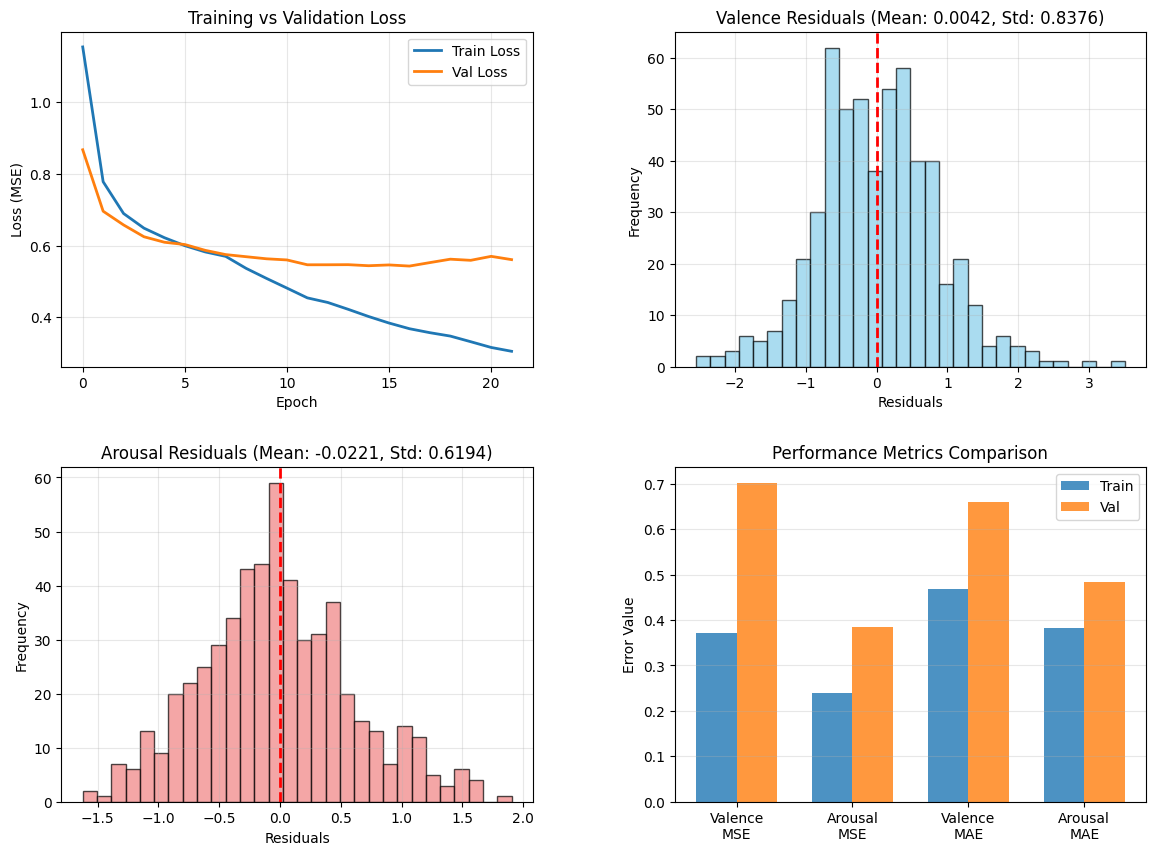

Visualization saved as 'full_baseline_performance.png'


In [52]:

import seaborn as sns

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Training vs Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4. Valence residuals distribution
ax4 = fig.add_subplot(gs[0, 1])
valence_residuals = y_val_np[:, 0] - val_preds_np[:, 0]
ax4.hist(valence_residuals, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Valence Residuals (Mean: {valence_residuals.mean():.4f}, Std: {valence_residuals.std():.4f})')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.grid(True, alpha=0.3)

# 5. Arousal residuals distribution
ax5 = fig.add_subplot(gs[1, 0])
arousal_residuals = y_val_np[:, 1] - val_preds_np[:, 1]
ax5.hist(arousal_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Frequency')
ax5.set_title(f'Arousal Residuals (Mean: {arousal_residuals.mean():.4f}, Std: {arousal_residuals.std():.4f})')
ax5.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax5.grid(True, alpha=0.3)

# 9. Performance metrics comparison
ax9 = fig.add_subplot(gs[1, 1])
metrics_names = ['Valence\nMSE', 'Arousal\nMSE', 'Valence\nMAE', 'Arousal\nMAE']
train_metrics = [train_mse_valence, train_mse_arousal, train_mae_valence, train_mae_arousal]
val_metrics = [val_mse_valence, val_mse_arousal, val_mae_valence, val_mae_arousal]

x = np.arange(len(metrics_names))
width = 0.35
ax9.bar(x - width/2, train_metrics, width, label='Train', alpha=0.8)
ax9.bar(x + width/2, val_metrics, width, label='Val', alpha=0.8)
ax9.set_ylabel('Error Value')
ax9.set_title('Performance Metrics Comparison')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics_names)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.savefig('full_baseline_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'full_baseline_performance.png'")


# Analysis

In [59]:

# ANALYSIS 1: Create CSV comparing predictions vs actuals
import pandas as pd
import numpy as np

# Rebuild val DataFrame aligned to valid_val_idx
val_analysis = val_targets[valid_val_idx].reset_index(drop=True).copy()
# Merge is_words from val_LIWC (in case val_targets doesn't have this column)
if 'is_words' not in val_analysis.columns:
    val_analysis['is_words'] = val_LIWC['is_words'][valid_val_idx].values

# Add predictions and errors
val_analysis['pred_valence']  = val_preds_np[:, 0]
val_analysis['pred_arousal']  = val_preds_np[:, 1]
val_analysis['err_valence']   = val_analysis['valence'] - val_analysis['pred_valence']
val_analysis['err_arousal']   = val_analysis['arousal'] - val_analysis['pred_arousal']
val_analysis['abs_err_valence'] = val_analysis['err_valence'].abs()
val_analysis['abs_err_arousal'] = val_analysis['err_arousal'].abs()
val_analysis['performance_arousal'] = val_analysis['abs_err_arousal'].apply(
    lambda x: 'good' if x < 0.3 else ('medium' if x < 0.6 else 'poor')
)
val_analysis['performance_valence'] = val_analysis['abs_err_valence'].apply(
    lambda x: 'good' if x < 0.3 else ('medium' if x < 0.6 else 'poor')
)

# Save full CSV
val_analysis.to_csv('Analysis/analysis_predictions.csv', index=False)

print(f"Saved Analysis/analysis_predictions.csv  ({len(val_analysis)} rows)")


Saved Analysis/analysis_predictions.csv  (553 rows)


In [54]:

# ANALYSIS 2: POS importance for arousal AND valence prediction

import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")

def get_pos_counts(text):
    doc = nlp(str(text))
    counts = defaultdict(int)
    for token in doc:
        if not token.is_space:
            counts[token.pos_] += 1
    total = max(sum(counts.values()), 1)
    return {pos: cnt / total for pos, cnt in counts.items()}

print("Computing POS features for val set (this may take ~30 seconds)...")
pos_records = [get_pos_counts(t) for t in val_analysis['text']]
pos_df = pd.DataFrame(pos_records).fillna(0)

pos_df['abs_err_arousal'] = val_analysis['abs_err_arousal'].values
pos_df['abs_err_valence'] = val_analysis['abs_err_valence'].values
pos_df['arousal']         = val_analysis['arousal'].values
pos_df['valence']         = val_analysis['valence'].values
pos_df['perf_arousal']    = val_analysis['performance_arousal'].values
pos_df['perf_valence']    = val_analysis['performance_valence'].values

meta_cols = ['abs_err_arousal','abs_err_valence','arousal','valence','perf_arousal','perf_valence']
pos_cols = [c for c in pos_df.columns if c not in meta_cols]

# --- AROUSAL ---
corr_arousal_err  = pos_df[pos_cols].corrwith(pos_df['abs_err_arousal']).sort_values(key=abs, ascending=False)
corr_arousal_true = pos_df[pos_cols].corrwith(pos_df['arousal']).sort_values(key=abs, ascending=False)
print("\n=== POS correlation with AROUSAL absolute error ===")
print(corr_arousal_err.round(4).to_string())
print("\n=== POS correlation with TRUE AROUSAL score ===")
print(corr_arousal_true.round(4).to_string())
print("\n=== Mean POS ratios: good vs poor AROUSAL predictions ===")
print(pos_df.groupby('perf_arousal')[pos_cols].mean().round(4).T.to_string())

# --- VALENCE ---
corr_valence_err  = pos_df[pos_cols].corrwith(pos_df['abs_err_valence']).sort_values(key=abs, ascending=False)
corr_valence_true = pos_df[pos_cols].corrwith(pos_df['valence']).sort_values(key=abs, ascending=False)
print("\n=== POS correlation with VALENCE absolute error ===")
print(corr_valence_err.round(4).to_string())
print("\n=== POS correlation with TRUE VALENCE score ===")
print(corr_valence_true.round(4).to_string())
print("\n=== Mean POS ratios: good vs poor VALENCE predictions ===")
print(pos_df.groupby('perf_valence')[pos_cols].mean().round(4).T.to_string())

# backward-compatible aliases
correlations      = corr_arousal_err
corr_with_arousal = corr_arousal_true


Computing POS features for val set (this may take ~30 seconds)...

=== POS correlation with AROUSAL absolute error ===
PROPN   -0.1452
DET      0.1015
VERB     0.0976
INTJ    -0.0886
NOUN     0.0780
ADP      0.0701
PUNCT   -0.0633
NUM      0.0611
PRON     0.0549
ADJ      0.0449
PART     0.0401
AUX      0.0353
SYM      0.0311
SCONJ    0.0240
CCONJ    0.0235
ADV      0.0138
X        0.0058

=== POS correlation with TRUE AROUSAL score ===
PROPN   -0.1682
PRON     0.0967
AUX      0.0874
ADJ      0.0856
NOUN     0.0721
DET      0.0715
PUNCT   -0.0691
VERB     0.0600
NUM     -0.0520
PART     0.0452
SYM     -0.0452
X       -0.0434
ADP      0.0283
ADV      0.0257
INTJ    -0.0038
CCONJ    0.0008
SCONJ    0.0006

=== Mean POS ratios: good vs poor AROUSAL predictions ===
perf_arousal    good  medium    poor
ADJ           0.1856  0.1881  0.1889
PUNCT         0.2923  0.2860  0.2524
INTJ          0.0043  0.0054  0.0008
PRON          0.0585  0.0588  0.0725
ADV           0.0339  0.0384  0.0396
VERB   

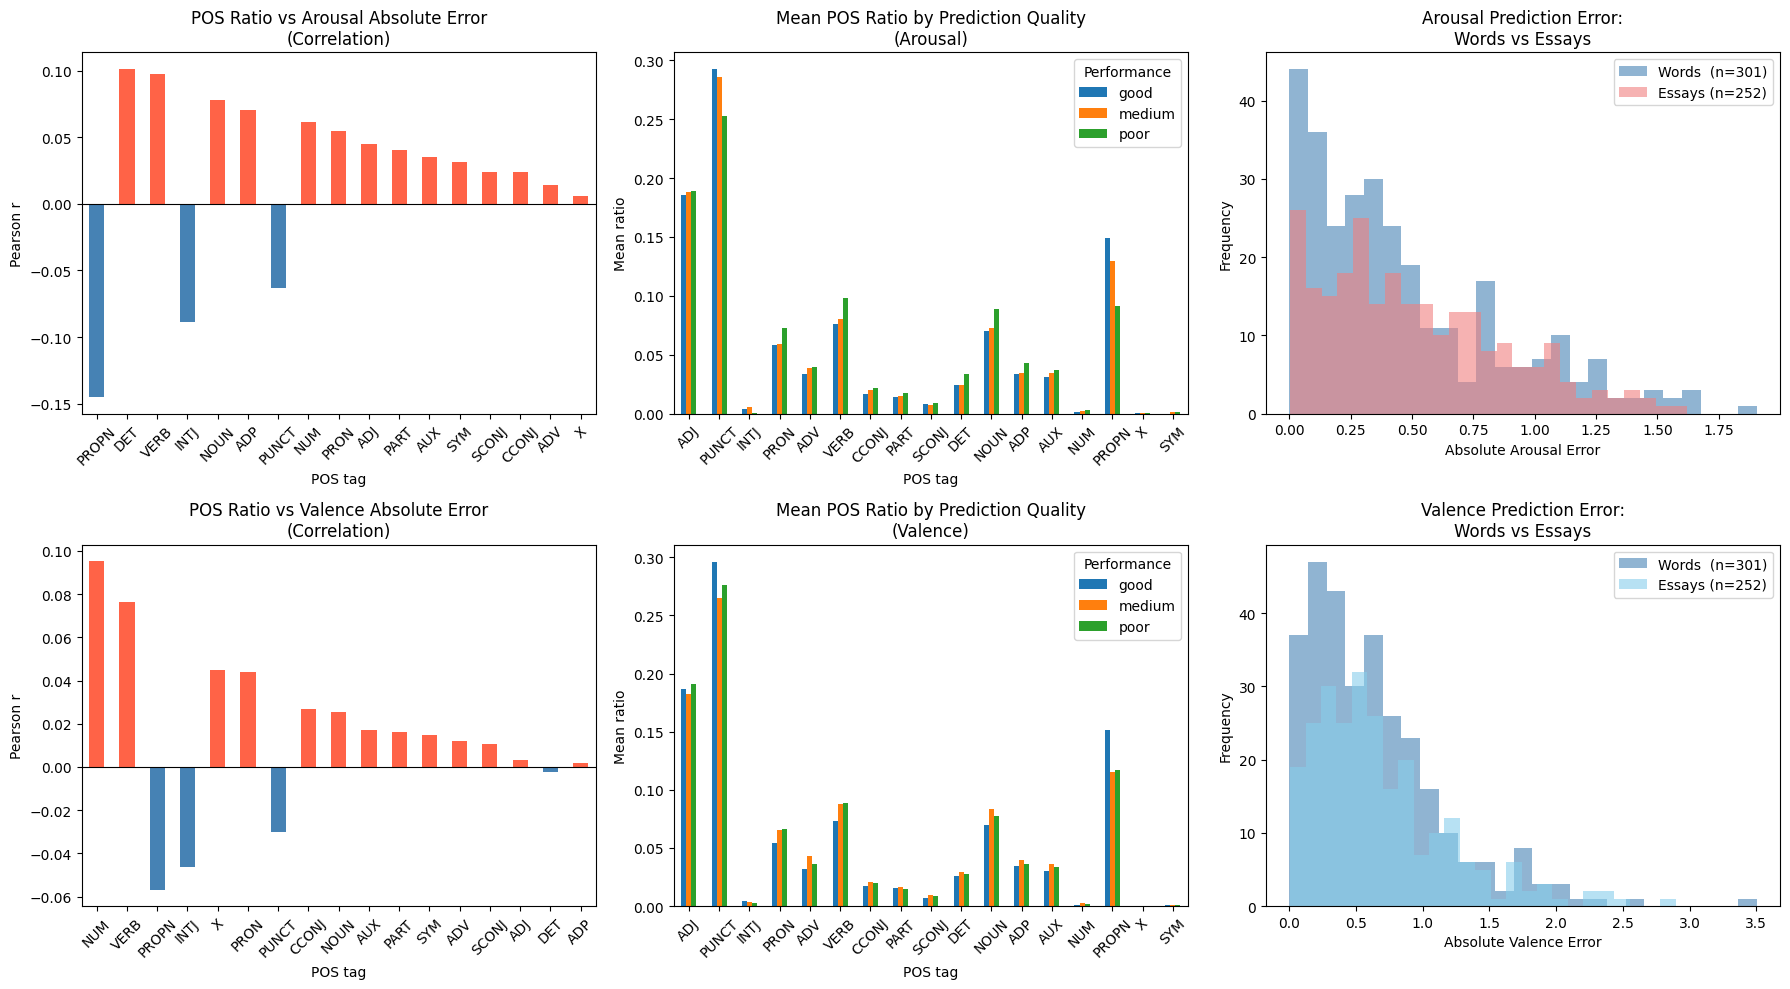

Saved Analysis/analysis_linguistic_patterns.png
Saved Analysis/analysis_with_pos.csv  (553 rows, 33 cols)
Saved Analysis/analysis_essays_summary.csv  (252 essays)


In [55]:

# ANALYSIS 3: Linguistic pattern visualisation (Arousal + Valence) + export CSV

import matplotlib.pyplot as plt
import seaborn as sns

pos_cols_plot = pos_cols  # reuse from ANALYSIS 2

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row, (target, err_col, perf_col, corr_err, color) in enumerate([
    ('Arousal', 'abs_err_arousal', 'perf_arousal', corr_arousal_err, 'lightcoral'),
    ('Valence', 'abs_err_valence', 'perf_valence', corr_valence_err, 'skyblue'),
]):
    # --- (a) POS correlation bar chart ---
    ax = axes[row, 0]
    corr_err.plot(kind='bar', ax=ax, color=['tomato' if v > 0 else 'steelblue' for v in corr_err])
    ax.set_title(f'POS Ratio vs {target} Absolute Error\n(Correlation)')
    ax.set_xlabel('POS tag')
    ax.set_ylabel('Pearson r')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.tick_params(axis='x', rotation=45)

    # --- (b) Mean POS ratios: good vs poor ---
    ax = axes[row, 1]
    group_means = pos_df.groupby(perf_col)[pos_cols_plot].mean().T
    group_means.plot(kind='bar', ax=ax)
    ax.set_title(f'Mean POS Ratio by Prediction Quality\n({target})')
    ax.set_xlabel('POS tag')
    ax.set_ylabel('Mean ratio')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Performance')

    # --- (c) Error distribution: words vs essays ---
    ax = axes[row, 2]
    words_e  = val_analysis[val_analysis['is_words'] == True][err_col]
    essays_e = val_analysis[val_analysis['is_words'] == False][err_col]
    ax.hist(words_e,  bins=25, alpha=0.6, label=f'Words  (n={len(words_e)})',  color='steelblue')
    ax.hist(essays_e, bins=25, alpha=0.6, label=f'Essays (n={len(essays_e)})', color=color)
    ax.set_xlabel(f'Absolute {target} Error')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{target} Prediction Error:\nWords vs Essays')
    ax.legend()

plt.tight_layout()
plt.savefig('Analysis/analysis_linguistic_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved Analysis/analysis_linguistic_patterns.png")

# ----- Export CSVs -----
full_export = val_analysis.copy()
for col in pos_cols_plot:
    full_export[f'pos_{col}'] = pos_df[col].values

full_export.to_csv('Analysis/analysis_with_pos.csv', index=False)
print(f"Saved Analysis/analysis_with_pos.csv  ({len(full_export)} rows, {len(full_export.columns)} cols)")

essays_df = full_export[full_export['is_words'] == False].copy()
essays_df['text_snippet'] = essays_df['text'].str[:60]
essays_summary = essays_df[['user_id','text_id','text_snippet',
                             'valence','arousal',
                             'pred_valence','pred_arousal',
                             'abs_err_valence','abs_err_arousal',
                             'performance_valence','performance_arousal']].sort_values('abs_err_arousal', ascending=False)
essays_summary.to_csv('Analysis/analysis_essays_summary.csv', index=False)
print(f"Saved Analysis/analysis_essays_summary.csv  ({len(essays_summary)} essays)")


# Ablation Study

In [57]:

# ---------- helper: train one ablation model ----------
def run_ablation(name, use_liwc, use_emb, use_sim, use_is_words,
                 use_token_num, use_feeling_rep, use_user_emb,
                 train_liwc, val_liwc, train_emb, val_emb,
                 train_sim, val_sim, train_isw, val_isw,
                 train_tok, val_tok, train_feel, val_feel,
                 train_uid_tensor, val_uid_tensor, num_users,
                 y_train_tensor, y_val_tensor, device,
                 num_epochs=100, batch_size=32, patience=5, lr=1e-4,
                 hidden_dim=512, user_embedding_dim=32):

    # Fix seed at the start of every run so results are comparable
    set_seed(SEED)

    # Build feature matrices
    parts_train, parts_val = [], []
    if use_liwc:
        parts_train.append(torch.tensor(train_liwc, dtype=torch.float32).to(device))
        parts_val.append(torch.tensor(val_liwc,     dtype=torch.float32).to(device))
    if use_emb:
        parts_train.append(torch.tensor(train_emb, dtype=torch.float32).to(device))
        parts_val.append(torch.tensor(val_emb,     dtype=torch.float32).to(device))
    if use_sim:
        parts_train.append(torch.tensor(train_sim, dtype=torch.float32).to(device))
        parts_val.append(torch.tensor(val_sim,     dtype=torch.float32).to(device))
    if use_is_words:
        parts_train.append(torch.tensor(train_isw,  dtype=torch.float32).to(device))
        parts_val.append(torch.tensor(val_isw,      dtype=torch.float32).to(device))
    if use_token_num:
        parts_train.append(torch.tensor(train_tok,  dtype=torch.float32).to(device))
        parts_val.append(torch.tensor(val_tok,      dtype=torch.float32).to(device))
    if use_feeling_rep:
        parts_train.append(torch.tensor(train_feel, dtype=torch.float32).to(device))
        parts_val.append(torch.tensor(val_feel,     dtype=torch.float32).to(device))

    if parts_train:
        X_tr = torch.cat(parts_train, dim=1)
        X_va = torch.cat(parts_val,   dim=1)
        feat_dim = X_tr.shape[1]
    else:
        feat_dim = 0
        X_tr = torch.zeros(y_train_tensor.shape[0], 0).to(device)
        X_va = torch.zeros(y_val_tensor.shape[0],   0).to(device)

    # Model with optional user embedding
    class AblationMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.use_user = use_user_emb
            if use_user_emb:
                self.user_emb = nn.Embedding(num_users, user_embedding_dim)
                total_in = feat_dim + user_embedding_dim
            else:
                total_in = max(feat_dim, 1)

            self.net = nn.Sequential(
                nn.Linear(total_in, hidden_dim),
                nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(hidden_dim // 2, hidden_dim // 4),
                nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(hidden_dim // 4, 2),
            )

        def forward(self, x, uid):
            if self.use_user:
                ue = self.user_emb(uid)
                if x.shape[1] > 0:
                    x = torch.cat([x, ue], dim=1)
                else:
                    x = ue
            elif x.shape[1] == 0:
                # Edge case: no features and no user emb — use constant 1 as placeholder
                x = torch.ones(x.shape[0], 1, device=x.device)
            return self.net(x)

    m = AblationMLP().to(device)
    for pname, p in m.named_parameters():
        if 'weight' in pname and p.dim() > 1:
            nn.init.xavier_uniform_(p, gain=0.5)
        elif 'bias' in pname:
            nn.init.zeros_(p)
        elif 'user_emb' in pname:
            nn.init.normal_(p, 0, 0.01)

    opt  = torch.optim.Adam(m.parameters(), lr=lr)
    crit = nn.MSELoss()
    best_val, best_state, pat_cnt = float('inf'), None, 0
    t0   = time.time()

    for epoch in range(num_epochs):
        m.train()
        # Shuffle each epoch
        perm      = torch.randperm(X_tr.shape[0], device=device)
        X_tr_shuf = X_tr[perm]
        uid_shuf  = train_uid_tensor[perm]
        y_tr_shuf = y_train_tensor[perm]
        for i in range(0, X_tr.shape[0], batch_size):
            bx = X_tr_shuf[i:i+batch_size]
            bu = uid_shuf[i:i+batch_size]
            by = y_tr_shuf[i:i+batch_size]
            opt.zero_grad()
            loss = crit(m(bx, bu), by)
            if torch.isnan(loss): break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            opt.step()

        m.eval()
        with torch.no_grad():
            vl = crit(m(X_va, val_uid_tensor), y_val_tensor).item()

        if vl < best_val:
            best_val   = vl
            best_state = copy.deepcopy(m.state_dict())
            pat_cnt    = 0
        else:
            pat_cnt += 1
        if pat_cnt >= patience:
            break
    if best_state:
        m.load_state_dict(best_state)

    m.eval()
    with torch.no_grad():
        val_pred = m(X_va, val_uid_tensor).cpu().numpy()

    y_true  = y_val_tensor.cpu().numpy()
    mse_v   = mean_squared_error(y_true[:, 0], val_pred[:, 0])
    mse_a   = mean_squared_error(y_true[:, 1], val_pred[:, 1])
    mae_v   = mean_absolute_error(y_true[:, 0], val_pred[:, 0])
    mae_a   = mean_absolute_error(y_true[:, 1], val_pred[:, 1])
    elapsed = time.time() - t0

    print(f"  [{name:40s}]  Val MSE valence={mse_v:.4f}  arousal={mse_a:.4f}  "
          f"MAE v={mae_v:.4f} a={mae_a:.4f}  ({elapsed:.0f}s, epoch={epoch+1})")
    return dict(name=name, mse_valence=mse_v, mse_arousal=mse_a,
                mae_valence=mae_v, mae_arousal=mae_a,
                mse_mean=(mse_v+mse_a)/2, mae_mean=(mae_v+mae_a)/2)


# ---------- define ablation conditions ----------
# (name, use_liwc, use_emb, use_sim, use_is_words, use_token_num, use_feeling_rep, use_user_emb)
conditions = [
    ("All features (full)",         True,  True,  True,  True,  True,  True,  True),
    ("No LIWC",                     False, True,  True,  True,  True,  True,  True),
    ("No Embedding",                True,  False, True,  True,  True,  True,  True),
    ("No Sims",                     True,  True,  False, True,  True,  True,  True),
    ("No is_words",                 True,  True,  True,  False, True,  True,  True),
    ("No token_num",                True,  True,  True,  True,  False, True,  True),
    ("No feeling_rep",              True,  True,  True,  True,  True,  False, True),
    ("No User Embedding",           True,  True,  True,  True,  True,  True,  False),
    ("LIWC only",                   True,  False, False, False, False, False, False),
    ("Embedding only",              False, True,  False, False, False, False, False),
    ("Sims only",                   False, False, True,  False, False, False, False),
    ("is_words only",               False, False, False, True,  False, False, False),
    ("token_num only",              False, False, False, False, True,  False, False),
    ("feeling_rep only",            False, False, False, False, False, True,  False),
    ("User Embedding only",         False, False, False, False, False, False, True),
    ("LIWC + User Emb",             True,  False, False, False, False, False, True),
    ("Embedding + User Emb",        False, True,  False, False, False, False, True),
    ("Sims + User Emb",             False, False, True,  False, False, False, True),
    ("feeling_rep + User Emb",      False, False, False, False, False, True,  True),
]

print("Running ablation study...")
results = []
for cond in conditions:
    r = run_ablation(
        name=cond[0],
        use_liwc=cond[1],        use_emb=cond[2],         use_sim=cond[3],
        use_is_words=cond[4],    use_token_num=cond[5],
        use_feeling_rep=cond[6], use_user_emb=cond[7],
        train_liwc=train_liwc_features, val_liwc=val_liwc_features,
        train_emb=train_emb_features,   val_emb=val_emb_features,
        train_sim=train_sim_features,   val_sim=val_sim_features,
        train_isw=train_is_words,       val_isw=val_is_words,
        train_tok=train_token_num,      val_tok=val_token_num,
        train_feel=train_feeling_rep,   val_feel=val_feeling_rep,
        train_uid_tensor=train_user_ids_tensor,
        val_uid_tensor=val_user_ids_tensor,
        num_users=num_unique_users,
        y_train_tensor=y_train_tensor, y_val_tensor=y_val_tensor,
        device=device,
    )
    results.append(r)

ablation_df = pd.DataFrame(results).sort_values('mse_mean')
print("\nAblation results (sorted by mean MSE):")
print(ablation_df[['name','mse_valence','mse_arousal','mae_valence','mae_arousal']].to_string(index=False))

Running ablation study...
  [All features (full)                     ]  Val MSE valence=0.7016  arousal=0.3842  MAE v=0.6596 a=0.4836  (3s, epoch=22)
  [No LIWC                                 ]  Val MSE valence=0.7028  arousal=0.3715  MAE v=0.6521 a=0.4821  (2s, epoch=17)
  [No Embedding                            ]  Val MSE valence=0.7156  arousal=0.4102  MAE v=0.6648 a=0.5005  (3s, epoch=24)
  [No Sims                                 ]  Val MSE valence=0.7528  arousal=0.4077  MAE v=0.6813 a=0.5040  (2s, epoch=20)
  [No is_words                             ]  Val MSE valence=0.7123  arousal=0.3913  MAE v=0.6627 a=0.4928  (2s, epoch=20)
  [No token_num                            ]  Val MSE valence=0.7153  arousal=0.3908  MAE v=0.6659 a=0.4928  (2s, epoch=20)
  [No feeling_rep                          ]  Val MSE valence=0.6829  arousal=0.3901  MAE v=0.6476 a=0.4923  (3s, epoch=22)
  [No User Embedding                       ]  Val MSE valence=0.7563  arousal=0.4219  MAE v=0.6952 a=0.532

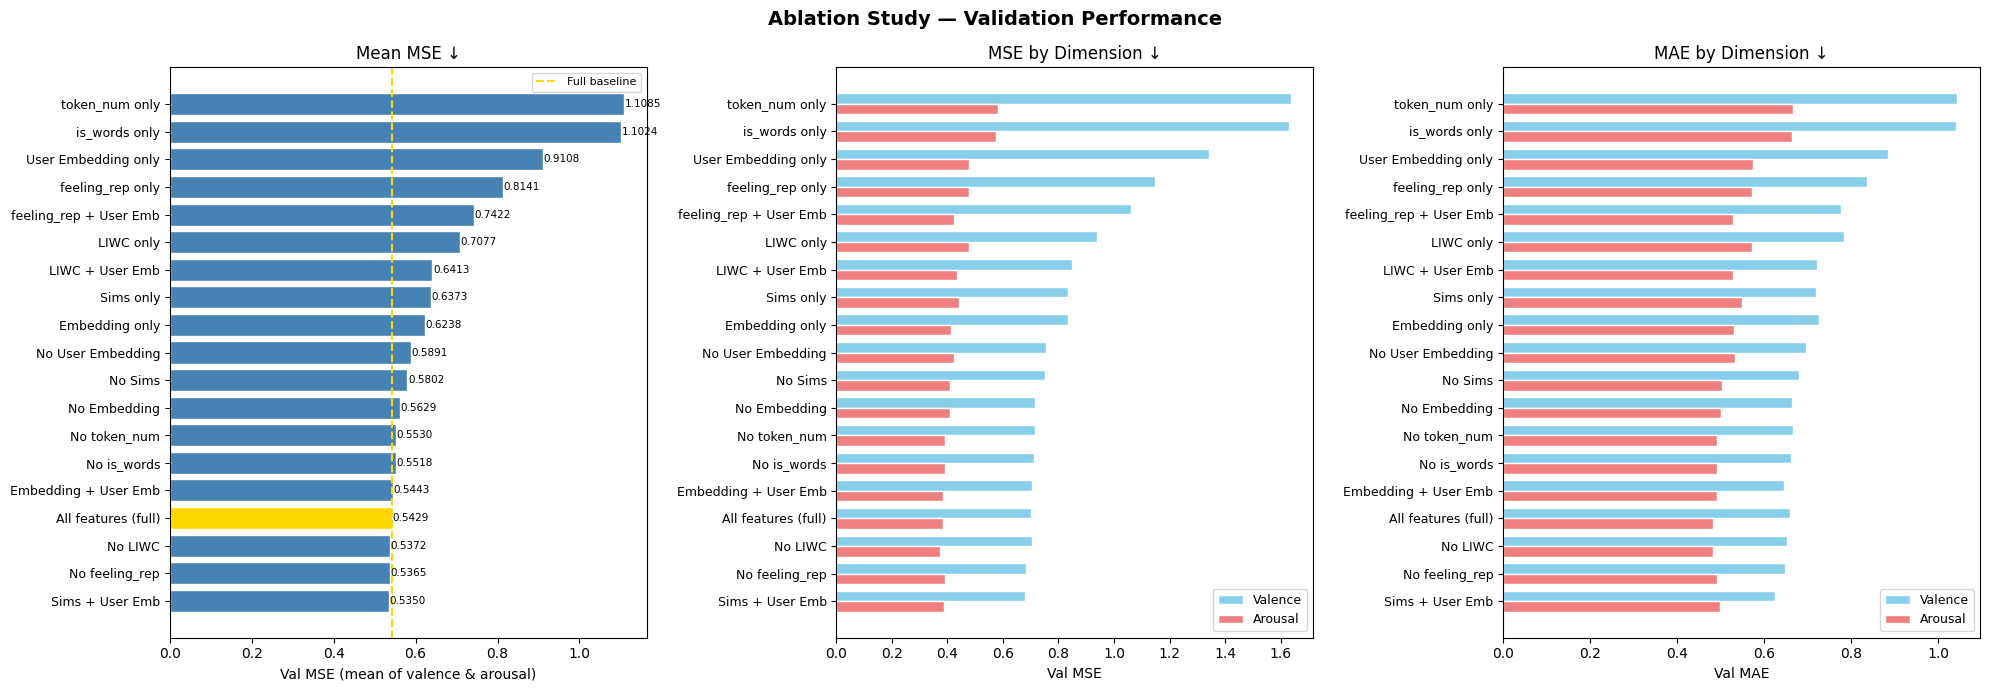

Saved Analysis/ablation_study.png
Saved Analysis/ablation_results.csv


In [58]:

# ---- Ablation Visualization ----

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle("Ablation Study — Validation Performance", fontsize=14, fontweight='bold')

# Sort by mean MSE for all plots
df_plot = ablation_df.sort_values('mse_mean', ascending=True).reset_index(drop=True)
names   = df_plot['name'].tolist()
y_pos   = range(len(names))

# Color: highlight "All features" in gold, others in steelblue
colors = ['gold' if 'full' in n else 'steelblue' for n in names]

# --- (a) Mean MSE ---
ax = axes[0]
bars = ax.barh(y_pos, df_plot['mse_mean'], color=colors, edgecolor='white')
ax.set_yticks(y_pos)
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Val MSE (mean of valence & arousal)')
ax.set_title('Mean MSE ↓')
ax.axvline(df_plot.loc[df_plot['name'].str.contains('full'), 'mse_mean'].values[0],
           color='gold', linestyle='--', linewidth=1.5, label='Full baseline')
ax.legend(fontsize=8)
for bar, v in zip(bars, df_plot['mse_mean']):
    ax.text(v + 0.001, bar.get_y() + bar.get_height()/2,
            f'{v:.4f}', va='center', fontsize=7.5)

# --- (b) MSE per dimension ---
ax = axes[1]
x = np.arange(len(names))
width = 0.38
ax.barh(x + width/2, df_plot['mse_valence'], width, label='Valence', color='skyblue',   edgecolor='white')
ax.barh(x - width/2, df_plot['mse_arousal'], width, label='Arousal', color='lightcoral', edgecolor='white')
ax.set_yticks(x)
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Val MSE')
ax.set_title('MSE by Dimension ↓')
ax.legend(fontsize=9)

# --- (c) MAE per dimension ---
ax = axes[2]
ax.barh(x + width/2, df_plot['mae_valence'], width, label='Valence', color='skyblue',   edgecolor='white')
ax.barh(x - width/2, df_plot['mae_arousal'], width, label='Arousal', color='lightcoral', edgecolor='white')
ax.set_yticks(x)
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Val MAE')
ax.set_title('MAE by Dimension ↓')
ax.legend(fontsize=9)

plt.tight_layout()
os.makedirs('Analysis', exist_ok=True)
plt.savefig('Analysis/ablation_study.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved Analysis/ablation_study.png")

# Also save CSV
ablation_df.to_csv('Analysis/ablation_results.csv', index=False)
print("Saved Analysis/ablation_results.csv")
